In [69]:
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from tqdm import tqdm
from statsmodels.stats.power import TTestIndPower
from statsmodels.stats.proportion import proportion_confint
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.power import tt_ind_solve_power
from scipy.stats import ttest_ind
from scipy.stats import median_test

# Кейс

Команда монетизации автоклассифайда раскатила новую ценовую политику на продавцов (листеров) в Новосибирске: повысили цены для всех на 10%. Основная гипотеза была в том, что вырастет месячный ARPPU (Средняя выручка на одного платящего пользователя). Ожидаемое изменение ARPPU +/- 5%. Нововведение раскатили через АБ-тест, но период теста был ограничен 1 месяцем данных. Поэтому размер выборки в тесте был ограничен. Нужно проанализировать результаты теста и понять, как "зашли" новые цены в Новосибирске.

# Загрузка данных

Данные представляют из себя таблицу с тратами пользователей (revenue) за период проведения теста. В таблице представлены только пользователи с тратами больше 0.

В колонке group показано, к какой группе относится пользователь: group = 0 - контрольная группа со старыми ценами, group = 1 - тестовая группа с новыми ценами.

In [85]:
df_bootstrap = pd.read_csv('bootstrap.csv')
df_bootstrap.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32115 entries, 0 to 32114
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   passport_id  32115 non-null  int64 
 1   region       32115 non-null  object
 2   revenue      32115 non-null  int64 
 3   group        32115 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1003.7+ KB


In [87]:
df_bootstrap.head(5)

,passport_id,region,revenue,group
0,135342321,Новосибирск,320,0
1,142791180,Новосибирск,2173,1
2,123514803,Новосибирск,215,0
3,124568474,Новосибирск,1720,0
4,141887661,Новосибирск,645,0


# Размер эффекта

In [17]:
mean_revenue_group_0 = df_boostrap[df_boostrap['group'] == 0] ['revenue'].mean()
mean_revenue_group_1 = df_boostrap[df_boostrap['group'] == 1] ['revenue'].mean()
abs_effect = mean_revenue_group_1 - mean_revenue_group_0
print(f"Среднее revenue для группы 0: {mean_revenue_group_0:.2f}")
print(f"Среднее revenue для группы 1: {mean_revenue_group_1:.2f}")
print(f"Абсолютный наблюдаемый эффект между группами: {abs_effect:.2f}")

Среднее revenue для группы 0: 1534.56
Среднее revenue для группы 1: 1587.76
Абсолютный наблюдаемый эффект между группами: 53.20


In [19]:
std_0 = df_boostrap[df_boostrap['group'] == 0] ['revenue'].std()
cohen_d = (mean_revenue_group_1 - mean_revenue_group_0) / std_0
print(f"Эффект d Коэна: {cohen_d:.4f}")

Эффект d Коэна: 0.0068


# Размер выборки

In [25]:
# Расчёт размера выборки, необходимый для детекции 5% относительных процентов
cohen_d = mean_revenue_group_0 * 0.05 / std_0

analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size = cohen_d, alpha = 0.05, power = 0.8, alternative='two-sided')

print (f"Эффект d Коэна для 5% изменения на исторических данных: {cohen_d:.4f}")
print(f"Необходимый размер выборки на группу: {round(sample_size)}")

Эффект d Коэна для 5% изменения на исторических данных: 0.0098
Необходимый размер выборки на группу: 162949


## Критерий Манна-Уитни

In [28]:
def get_beta_many_mw_ab_tests(hist_data, rel_lift, sample_size, n_sim):
    '''
    функция проводящая многократно Манна_Уитни тесты с заданными параметрами
    hist_data - исторические данные, которые используем для генерации выборок А и Б
    rel_lift - относительный рост средней, задаваемый для проверки мощности. Относительный MDE
    sample_size - размер выборки в тесте
    n_sim - кол-во симуляций для одного размера выборки
    output - возвращает alpha, beta и 95%-доверительные интервалы
    '''
    aa_means_diff_list = []
    ab_means_diff_list = []
    aa_p_val_list = []
    ab_p_val_list = []

    for i in tqdm(range(n_sim), disable = True):

        sample_a_1 = np.random.choice(hist_data, size = sample_size) # контрольная группа без эффекта
        sample_a_2 = np.random.choice(hist_data, size = sample_size) # тестовая группа без эффекта
        sample_b = np.random.choice(hist_data, size = sample_size)*(1+rel_lift) # тестовая группа c эффектом

        aa_means_diff = sample_a_1.mean() - sample_a_2.mean()
        ab_means_diff = sample_a_1.mean() - sample_b.mean()
        aa_p_val = mannwhitneyu(sample_a_1, sample_a_2)[1] # применем MW для АА версии
        ab_p_val = mannwhitneyu(sample_a_1, sample_b)[1] # применяем MW для AB

        aa_means_diff_list.append(aa_means_diff)
        ab_means_diff_list.append(ab_means_diff)
        aa_p_val_list.append(aa_p_val)
        ab_p_val_list.append(ab_p_val)

    alpha = np.sum(np.array(aa_p_val_list) < 0.05) / n_sim
    power = np.sum(np.array(ab_p_val_list) < 0.05) / n_sim

    alpha_ci = proportion_confint(np.sum(np.array(aa_p_val_list) < 0.05), n_sim, alpha=0.05)
    power_ci = proportion_confint(np.sum(np.array(ab_p_val_list) < 0.05), n_sim, alpha=0.05)

    output = {'alpha':alpha, 'power': power, 'alpha_ci':alpha_ci, 'power_ci':power_ci}

    return(output)

In [30]:
sample_size_list = np.arange(500, 5000, 100) # зададим линейное пространство размера выборок, по которому мы будем перебирать

mw_power_list = []
mw_lower_power_ci_list = []
mw_upper_power_ci_list = []
hist_data = df_boostrap[df_boostrap['group']==0]['revenue']

np.random.seed(1)
# прогоним циклом, где для каждого размера выборки мы численно находим мощность и другие параметры
for i in tqdm(sample_size_list):
    mw_output = get_beta_many_mw_ab_tests(hist_data, 0.05, i, 1000)

    mw_alpha = mw_output['alpha']
    mw_power = mw_output['power']
    mw_power_ci = mw_output['power_ci']
    mw_power_list.append(mw_power)
    mw_lower_power_ci_list.append(mw_power_ci[0])
    mw_upper_power_ci_list.append(mw_power_ci[1])

100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:54<00:00,  2.55s/it]


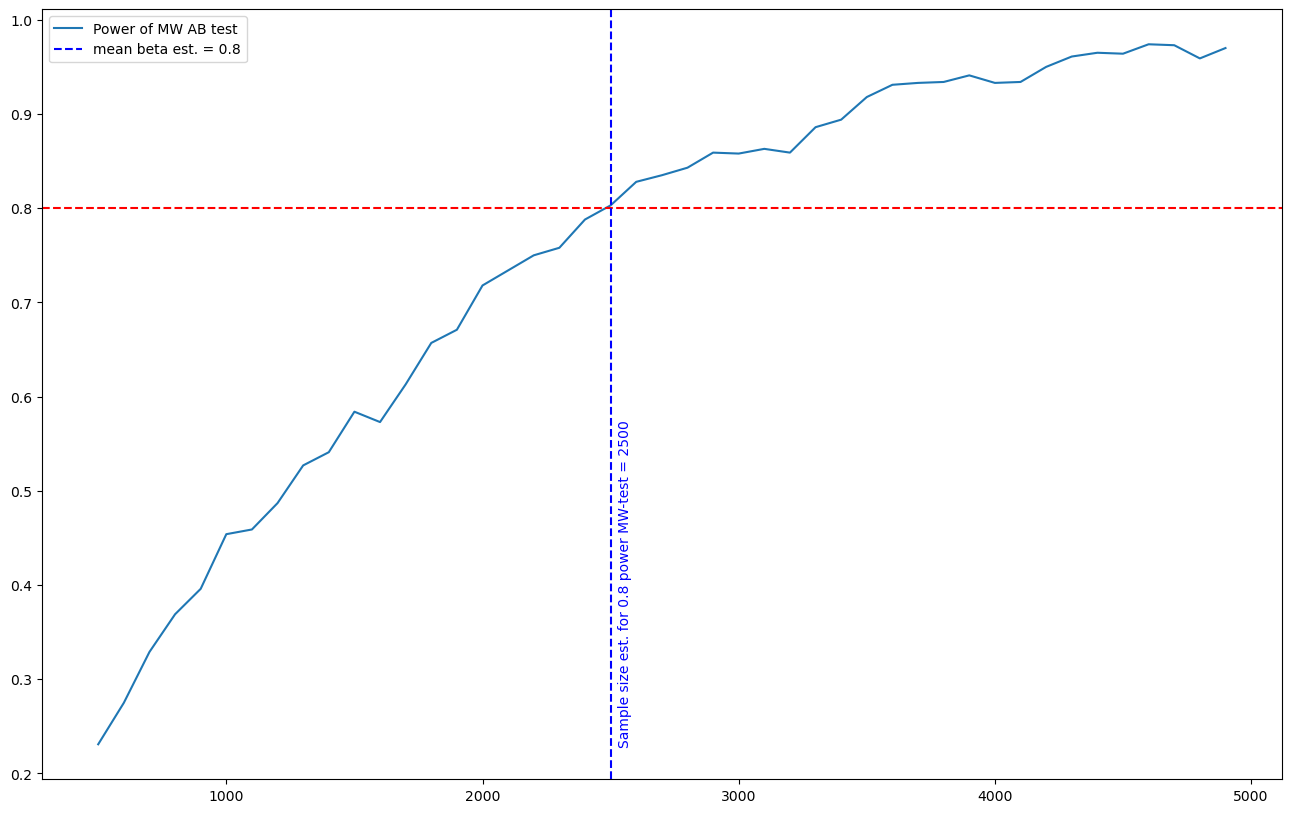

In [32]:
# Отрисуем результаты симуляции, полученные на прошлом этапе. Посмотрим рост мощности теста.
mw_power_est_index = np.argmax(np.array(mw_power_list) >= 0.8)

plt.figure(figsize=(16,10))
sns.lineplot(x = sample_size_list, y = mw_power_list, label = 'Power of MW AB test')

plt.axhline(0.8, color = 'red', linestyle ='--')
plt.axvline(sample_size_list[mw_power_est_index], color = 'blue', linestyle ='--', label = 'mean beta est. = 0.8')
plt.text(sample_size_list[mw_power_est_index] + 30, np.min(mw_power_list), 'Sample size est. for 0.8 power MW-test = {}'.format(sample_size_list[mw_power_est_index]), rotation = 'vertical', color = 'blue')

plt.legend()

In [34]:
print('Размер выборки необходимый Манна-Уитни, чтобы задетектить 5% изменение средних на исторических данных:', sample_size_list[mw_power_est_index])


Размер выборки необходимый Манна-Уитни, чтобы задетектить 5% изменение средних на исторических данных: 2500


## MDE

In [42]:
# размер выборки, необходимый для детекции наблюдаемого в реальных данных эффекта
effect_size = (mean_revenue_group_1 - mean_revenue_group_0) / std_0
alpha = 0.05       # Уровень значимости
power = 0.8        # Мощность
ratio = 1.0        # 50/50 между группами

# Расчёт
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=ratio)
print(f"Необходимый размер выборки на группу: {round(sample_size)}")

Необходимый размер выборки на группу: 338943


In [129]:
control_sd = df_boostrap[df_boostrap['group']==0]['revenue'].std()
MDE_std = tt_ind_solve_power(effect_size = None,
                       alpha = 0.05,
                       power = 0.8,
                       ratio = 1,
                       alternative = "two-sided",
                       nobs1 = 16057)
print('Стандартизированный MDE, который мы можем себе позволить на заданном дизайне эксперимента =', MDE_std)
print('Абсолютный MDE, который мы можем себе позволить на заданном дизайне эксперимента =', MDE_std * control_sd)

Стандартизированный MDE, который мы можем себе позволить на заданном дизайне эксперимента = 0.031268931322582474
Абсолютный MDE, который мы можем себе позволить на заданном дизайне эксперимента = 244.43987831375256


# Проверка стат.критерия

In [46]:
# функция для отрисовки графиков проверки критерия
def experiment_simulation_plot(alpha, aa_control_group_means, aa_test_group_means, aa_means_diffs_list, aa_stat_list, aa_p_val_list, ab_control_group_means, ab_test_group_means, ab_means_diffs_list, ab_stat_list, ab_p_val_list):
    '''
    aa_control_group_means - средние полученные по симуляциям в контрольной группе в AA-варианте симуляции
    aa_test_group_means - средние полученные по симуляциям в тестовой группе в AA-варианте симуляции
    aa_means_diffs_list - разница средних в AA-варианте симуляции
    aa_stat_list - значение критерия полученного по симуляциям в AA-варианте симуляции
    aa_p_val_list - p-value  полученные по симуляциям в AA-варианте симуляции

    ab_control_group_means - средние полученные по симуляциям в контрольной группе в AB-варианте симуляции
    ab_test_group_means - средние полученные по симуляциям в тестовой группе в AB-варианте симуляции
    ab_means_diffs_list - разница средних в AB-варианте симуляции
    ab_stat_list - значение критерия полученного по симуляциям в AB-варианте симуляции
    ab_p_val_list - p-value  полученные по симуляциям в AB-варианте симуляции

    '''

    # рассчитываем 95% доверительные интервалы для полученных численно alpha  и  beta
    alpha_ci = proportion_confint(np.sum(np.array(aa_p_val_list) < alpha), n_iter, alpha=0.05)
    power_ci = proportion_confint(np.sum(np.array(ab_p_val_list) < alpha), n_iter, alpha=0.05)

    # PLOT
    fig, axes = plt.subplots(2, 4, figsize=(15,10))

    ### AA subplots
    ### Первый ряд графиков посвящен АА-симуляциям.
    # График распределения средних в первой и второй выборках. Иллюстрирует тоже самое о чем говорит ЦПТ.
    sns.kdeplot(ax=axes[0,0], data = aa_control_group_means, color = 'blue')
    sns.kdeplot(ax=axes[0,0], data = aa_test_group_means, color = 'red')
    axes[0,0].set_title('AA: A|B group mean distribution')
    axes[0,0].axvline(x=np.quantile(aa_control_group_means, 0.5), linestyle = '--', color = 'blue', label = 'control mean')
    axes[0,0].axvline(x=np.quantile(aa_test_group_means, 0.5), linestyle = '--', color = 'red', label = 'test mean')
    axes[0,0].legend(loc='lower right')

    # График распределения разницы между средними
    sns.kdeplot(ax=axes[0,1], data = aa_means_diffs_list)
    axes[0,1].axvline(x=0, linestyle = '--', color = 'red', label = 'zero difference')
    axes[0,1].axvline(x=np.quantile(aa_means_diffs_list, alpha/2), linestyle = '--', color = 'grey', label = '95% conf interval for diff')
    axes[0,1].axvline(x=np.quantile(aa_means_diffs_list, 1-alpha/2), linestyle = '--', color = 'grey')
    axes[0,1].set_title('AA: Means diffs distribution')
    axes[0,1].legend(loc='lower right')

    # график распределения значения стат критерия. t-статистика для t-теста
    sns.kdeplot(ax=axes[0,2], data = aa_stat_list)
    axes[0,2].set_title('AA: stats distribution')

    # график распределения p-value
    sns.kdeplot(ax=axes[0,3], data = aa_p_val_list)
    axes[0,3].set_title('AA: p-values distribution')
    axes[0,3].axvline(x=alpha, linestyle = '--', color = 'red', label = 'alpha')
    axes[0,3].axvline(x=np.quantile(aa_p_val_list, 0.8), linestyle = '--', color = 'blue', label = '80% quantile for p-value')
    axes[0,3].legend(loc='lower right')

    ### AB subplots
    ### второй ряд графиков посвящен АБ-симуляциям
    # график распределения средних в первой и второй выборках. Иллюстрирует тоже самое о чем говорит ЦПТ
    sns.kdeplot(ax=axes[1,0], data = ab_control_group_means, color = 'blue')
    sns.kdeplot(ax=axes[1,0], data = ab_test_group_means, color = 'red')
    axes[1,0].set_title('AB: A|B group mean distribution')
    axes[1,0].axvline(x=np.quantile(ab_control_group_means, 0.5), linestyle = '--', color = 'blue', label = 'control mean')
    axes[1,0].axvline(x=np.quantile(ab_test_group_means, 0.5), linestyle = '--', color = 'red', label = 'test mean')
    axes[1,0].legend(loc='lower right')

    # график распределения разницы между средними
    sns.kdeplot(ax=axes[1,1], data = ab_means_diffs_list)
    axes[1,1].axvline(x=0, linestyle = '--', color = 'red', label = 'zero difference')
    axes[1,1].axvline(x=np.quantile(ab_means_diffs_list, alpha/2), linestyle = '--', color = 'grey', label = '95% conf interval for diff')
    axes[1,1].axvline(x=np.quantile(ab_means_diffs_list, 1-alpha/2), linestyle = '--', color = 'grey')
    axes[1,1].set_title('AB: Means diffs distribution')
    axes[1,1].legend(loc='lower right')

    # график распределения значения стат критерия. t-статистика для t-теста
    sns.kdeplot(ax=axes[1,2], data = ab_stat_list)
    axes[1,2].set_title('AB: stats distribution')

    # график распределения p-value
    sns.kdeplot(ax=axes[1,3], data = ab_p_val_list)
    axes[1,3].set_title('AB: p-values distribution')
    axes[1,3].axvline(x=alpha, linestyle = '--', color = 'red', label = 'alpha')
    axes[1,3].axvline(x=np.quantile(ab_p_val_list, 0.8), linestyle = '--', color = 'blue', label = '80% quantile for p-value')
    axes[1,3].legend(loc='lower right')

    # принтуем ключевые метрики
    print('Median means lift for AA simulation = ', np.median(aa_means_diffs_list))
    print('Alpha(FPR) = ', np.sum(np.array(aa_p_val_list) < alpha) / n_iter)
    print('Alpha 95% CI:', alpha_ci)
    print('Median means lift for AB simulation = ', np.median(ab_means_diffs_list))
    print('Power(TPR) = ', np.sum(np.array(ab_p_val_list) < alpha) / n_iter)
    print('Beta 95% CI:', power_ci)


## Проверка Манн-Уитни. Нахождение оценки мощности через симуляцию

Effect size = 0.006805431639567614
Number of simulations =  1000
Sample size =  338942


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:47<00:00,  5.96it/s]
C:\Users\ludwi\AppData\Local\Temp\ipykernel_7592\1338650896.py:77: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(ax=axes[1,3], data = ab_p_val_list)


Median means lift for AA simulation =  -0.12314791321227858
Alpha(FPR) =  0.052
Alpha 95% CI: (0.038238875263084865, 0.06576112473691513)
Median means lift for AB simulation =  76.59617810716895
Power(TPR) =  1.0
Beta 95% CI: (1.0, 1.0)


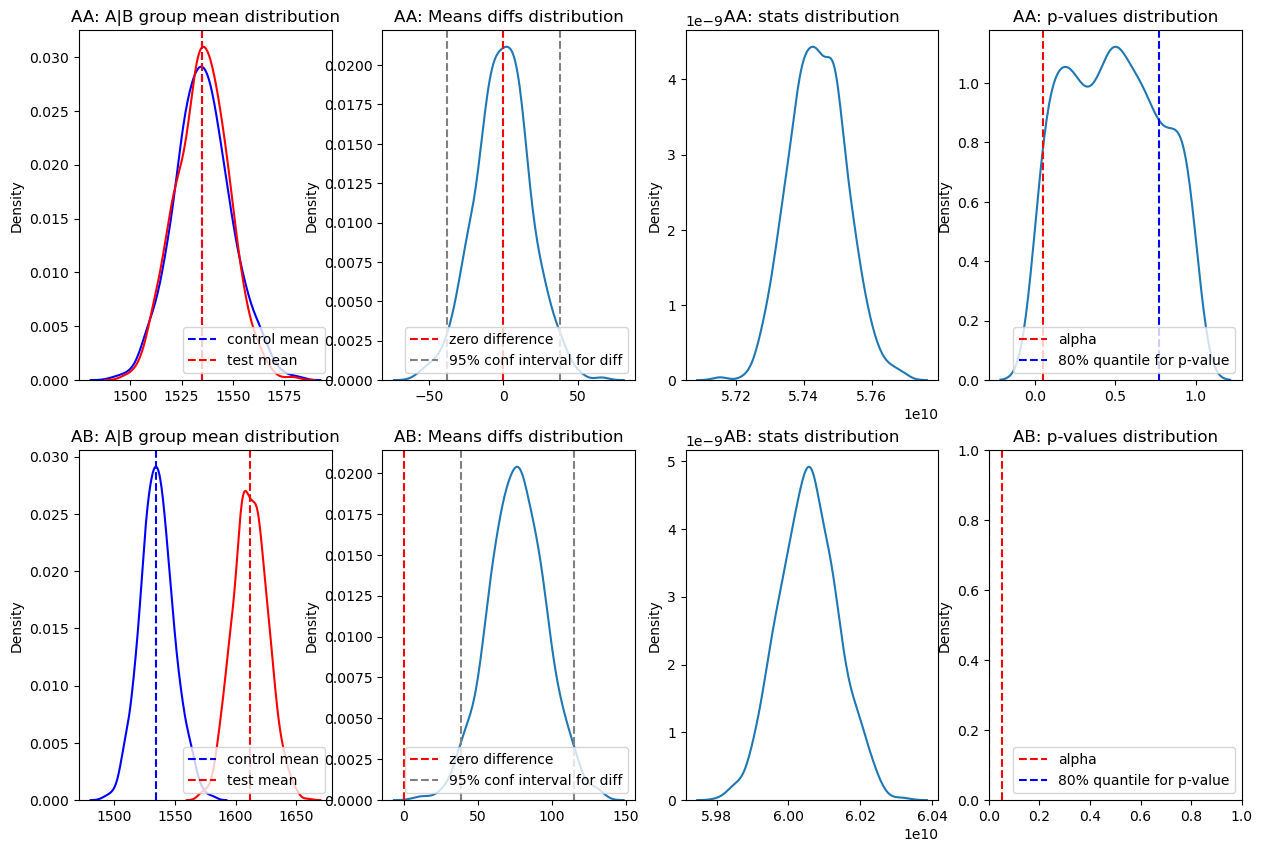

In [49]:
# Проверка Критерия Манна_Уитни на размер выборки нужный для t-test
alpha = 0.05
beta = 0.2
power = 1 - beta
rel_lift = 0.05
cohen_d_1 = (mean_revenue_group_1 - mean_revenue_group_0) / std_0
print('Effect size =', cohen_d_1)

n_iter = 1000
print('Number of simulations = ', n_iter)

sample_size = int(tt_ind_solve_power(effect_size=cohen_d_1, alpha=alpha, power=power, nobs1=None, ratio=1))
print('Sample size = ', sample_size)

aa_control_group_means = []
aa_test_group_means = []
ab_control_group_means = []
ab_test_group_means = []

aa_p_val_list = []
aa_u_stat_list = []
aa_means_diffs_list = []

ab_p_val_list = []
ab_u_stat_list = []
ab_means_diffs_list = []

np.random.seed(1) # задаем seed
for i in tqdm(range(n_iter)):
    sample_1 = np.random.choice(hist_data, size = sample_size)
    sample_2_zero_effect = np.random.choice(hist_data, size = sample_size)
    sample_2_with_effect = np.random.choice(hist_data, size = sample_size)*(1+rel_lift)

    aa_control_group_means.append(sample_1.mean())
    aa_test_group_means.append(sample_2_zero_effect.mean())

    ab_control_group_means.append(sample_1.mean())
    ab_test_group_means.append(sample_2_with_effect.mean())

    aa_means_diff = sample_2_zero_effect.mean() - sample_1.mean()
    ab_means_diff = sample_2_with_effect.mean() - sample_1.mean()

    aa_u_stat, aa_p_val = mannwhitneyu(sample_2_zero_effect, sample_1)
    ab_u_stat, ab_p_val = mannwhitneyu(sample_2_with_effect, sample_1)

    aa_p_val_list.append(aa_p_val)
    ab_p_val_list.append(ab_p_val)

    aa_u_stat_list.append(aa_u_stat)
    ab_u_stat_list.append(ab_u_stat)

    aa_means_diffs_list.append(aa_means_diff)
    ab_means_diffs_list.append(ab_means_diff)

experiment_simulation_plot(alpha = 0.05,
                           aa_control_group_means = aa_control_group_means,
                           aa_test_group_means = aa_test_group_means,
                           aa_means_diffs_list = aa_means_diffs_list,
                           aa_stat_list = aa_u_stat_list,
                           aa_p_val_list = aa_p_val_list,
                           ab_control_group_means = ab_control_group_means,
                           ab_test_group_means = ab_test_group_means,
                           ab_means_diffs_list = ab_means_diffs_list,
                           ab_stat_list = ab_u_stat_list,
                           ab_p_val_list = ab_p_val_list)


In [51]:
print('Мощность критерия Манна-Уитни с заданными параметрами симуляции составляет', (np.array(ab_p_val_list) < 0.05).sum() / n_iter)

Мощность критерия Манна-Уитни с заданными параметрами симуляции составляет 1.0


## Проверка T-test. Нахождение оценки мощности через симуляцию

Effect size = 0.009815084264946232
Estimated absolute effect = 76.72785419532325
Number of simulations =  1000
Sample size =  162948
Median means lift for AA simulation =  -1.401684948721936
Alpha(FPR) =  0.047
Alpha 95% CI: (0.033882729627025654, 0.060117270372974346)
Median means lift for AB simulation =  76.75856854116375
Power(TPR) =  0.798
Beta 95% CI: (0.7731157118634949, 0.8228842881365052)


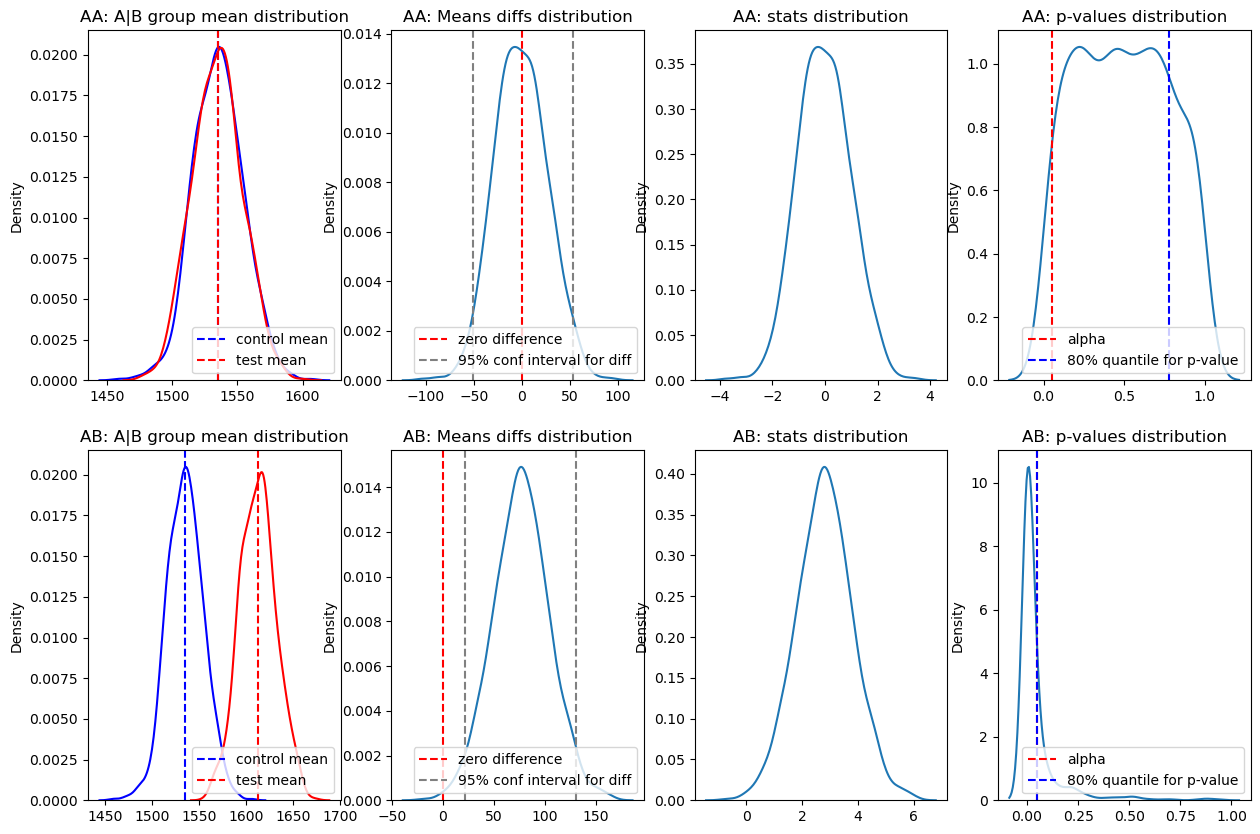

In [54]:
# определим дизайн теста
alpha = 0.05
beta = 0.2
std = df_boostrap[df_boostrap['group'] == 0] ['revenue'].std()
mean = df_boostrap[df_boostrap['group'] == 0] ['revenue'].mean()
power = 1 - beta
rel_lift = 0.05
abs_lift = mean*rel_lift #
effect_size = abs_lift / std

print('Effect size =', effect_size)
print('Estimated absolute effect =', abs_lift)

n_iter = 1000
print('Number of simulations = ', n_iter)

# находим размер выборки
sample_size = int(tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, nobs1=None, ratio=1))
print('Sample size = ', sample_size)

# создаем пустые листы, которые будут заполняться нужными значениями по мере работы цикла
aa_control_group_means = []
aa_test_group_means = []
ab_control_group_means = []
ab_test_group_means = []

aa_p_val_list = []
aa_t_stat_list = []
aa_means_diffs_list = []

ab_p_val_list = []
ab_t_stat_list = []
ab_means_diffs_list = []

# запускаем цикл многократной проверки (n_iter раз) разницы средних между двумя нормальными рапределениями

for i in range(n_iter):
    # генерируем 3 выборки одну тестовую и две контрольных. При этом эффект добавляем только в одной контрольной
    sample_1 = np.random.normal(mean, std, sample_size)
    sample_2_zero_effect = np.random.normal(mean*(1+0), std, sample_size) #
    sample_2_with_effect = np.random.normal(mean*(1+rel_lift), std, sample_size) # добавляем эффект
    
    aa_control_group_means.append(sample_1.mean())
    aa_test_group_means.append(sample_2_zero_effect.mean())
    
    ab_control_group_means.append(sample_1.mean())
    ab_test_group_means.append(sample_2_with_effect.mean())

    aa_means_diff = sample_2_zero_effect.mean() - sample_1.mean()
    ab_means_diff = sample_2_with_effect.mean() - sample_1.mean()
    
    aa_t_stat, aa_p_val = ttest_ind(sample_2_zero_effect, sample_1)
    ab_t_stat, ab_p_val = ttest_ind(sample_2_with_effect, sample_1)
    
    aa_p_val_list.append(aa_p_val)
    ab_p_val_list.append(ab_p_val)
    
    aa_t_stat_list.append(aa_t_stat)
    ab_t_stat_list.append(ab_t_stat)
    
    aa_means_diffs_list.append(aa_means_diff)
    ab_means_diffs_list.append(ab_means_diff)
    
# рисуем график
experiment_simulation_plot(alpha = 0.05,
                           aa_control_group_means = aa_control_group_means,
                           aa_test_group_means = aa_test_group_means,
                           aa_means_diffs_list = aa_means_diffs_list,
                           aa_stat_list = aa_t_stat_list,
                           aa_p_val_list = aa_p_val_list,
                           ab_control_group_means = ab_control_group_means,
                           ab_test_group_means = ab_test_group_means,
                           ab_means_diffs_list = ab_means_diffs_list,
                           ab_stat_list = ab_t_stat_list,
                           ab_p_val_list = ab_p_val_list)

In [56]:
print('Мощность t-test с заданными параметрами симуляции составляет', (np.array(ab_p_val_list) < 0.05).sum() / n_iter)

Мощность t-test с заданными параметрами симуляции составляет 0.798


# Проверка гипотезы

In [61]:
# Получаем данные по группам
group_0 = df_boostrap[df_boostrap['group'] == 0]['revenue']
group_1 = df_boostrap[df_boostrap['group'] == 1]['revenue']

# Двусторонний t-test 
t_stat, p_value = ttest_ind(group_0, group_1, equal_var=False)

print(f"📊 t-статистика: {t_stat:.4f}")
print(f"📉 p-value: {p_value:.4f}")

📊 t-статистика: -0.6200
📉 p-value: 0.5353


In [65]:
# Получаем данные по группам
group_0 = df_boostrap[df_boostrap['group'] == 0]['revenue']
group_1 = df_boostrap[df_boostrap['group'] == 1]['revenue']

# Манна-Уитни тест (двусторонний)
u_stat, p_value = mannwhitneyu(group_0, group_1, alternative='two-sided')

print(f"📊 U-статистика: {u_stat:.4f}")
print(f"📉 p-value: {p_value:.4f}")

📊 U-статистика: 137332553.5000
📉 p-value: 0.0000


In [71]:
# Получаем данные по группам
group_0 = df_boostrap[df_boostrap['group'] == 0]['revenue']
group_1 = df_boostrap[df_boostrap['group'] == 1]['revenue']

# Mood's median test
stat, p_value, med, table = median_test(group_0, group_1)

print(f"📊 Статистика теста Моода: {stat:.4f}")
print(f"📉 p-value: {p_value:.4f}")
print(f"🔹 Общая медиана (используется как порог): {med}")

📊 Статистика теста Моода: 108.8195
📉 p-value: 0.0000
🔹 Общая медиана (используется как порог): 480.0


- Мы не можем отвергнуть гипотезу H0 о равенстве средних между двумя группами. Т.е. средние между группами возможно отличаются, но мы не можем задетектить его значение меньше чем уровень +/- 240 тенге (MDE, который мы можем себе позволить на этих данных).
- Манна-Уитни точно нашел изменение характера распределения по результатам теста. p-value у него очень маленький. Скорее всего изменились квантили распределения. Что косвенно нам подтверждает и Медианный тест.
- Желательно провести анализ квантилей распределния через бутстрап. Тогда мы сможем дать менеджеру более детальный ответ о характере изменений в ARPPU после нашего теста.

# Bootstrap

## Kвантили распределения в обеих группах

In [89]:
#взглянем на квантили распределения в обеих группах
group_0 = df_bootstrap[df_bootstrap['group'] == 0]['revenue']
group_1 = df_bootstrap[df_bootstrap['group'] == 1]['revenue']

quantile_0 = group_0.quantile(0.7)
quantile_1 = group_1.quantile(0.7)
print(f"0.7 квантиль revenue для группы 0: {quantile_0}")
print(f"0.7 квантиль revenue для группы 1: {quantile_1}")

0.7 квантиль revenue для группы 0: 960.0
0.7 квантиль revenue для группы 1: 1128.0


In [91]:
# Найдём первый и третий квартили
q1_0 = group_0.quantile(0.25)
q3_0 = group_0.quantile(0.75)
q1_1 = group_1.quantile(0.25)
q3_1 = group_1.quantile(0.75)

# Рассчитаем межквартильный размах
iqr_0 = q3_0 - q1_0
iqr_1 = q3_1 - q1_1

print(f"Межквартильный размах для группы 0: {iqr_0}")
print(f"Межквартильный размах для группы 1: {iqr_1}")

Межквартильный размах для группы 0: 963.0
Межквартильный размах для группы 1: 1186.0


## Проверка гипотезы бутстрапом

In [96]:
# функция, возвращающая resample выборок resample_num раз
def get_resampled_data(sample, sample_size, resample_num):
    resampled_data = np.random.choice(sample, size = (resample_num, sample_size), replace=True)
    return(resampled_data)

In [98]:
# функция, которая из полученных выборок достает заданную статистику
def get_resampled_stats(resampled_data, stat):
    resampled_stats = stat(resampled_data, axis = 1)
    return(resampled_stats)

In [100]:
# функция, которая достает квантили из resample выборок
def get_resampled_quantile(resampled_data, q=0.5):
    resampled_stats = np.quantile(resampled_data, q=q, axis = 1)
    return(resampled_stats)

In [102]:
def bootstrap_ab_test(sample_data_A, sample_data_B, stat, resample_num, alpha, q):
    '''
    sample_data_A - значения в выборке А
    sample_data_B - значения в выборке B
    stat - можно передать оцениваемую функцию
    resample_num - количество итераций извлечения resample выборок в бутстрапе
    alpha - уровень значимости при проверке
    q - указывается если вы оцениваете определенный квантиль распределения

    '''
    # получаем бутстрапированные данные
    resampled_data_A = get_resampled_data(sample_data_A, len(sample_data_A), resample_num)
    resampled_data_B = get_resampled_data(sample_data_B, len(sample_data_B), resample_num)

    if q is not None:
        resampled_stats_A = get_resampled_quantile(resampled_data_A, q)
        resampled_stats_B = get_resampled_quantile(resampled_data_B, q)
    else:
        resampled_stats_A = get_resampled_stats(resampled_data_A, stat)
        resampled_stats_B = get_resampled_stats(resampled_data_B, stat)

    # рассчитываем разницу для статистики
    resampled_diffs = resampled_stats_B - resampled_stats_A

    # рассчитываем перцентильный бутстрап
    perc_ci = np.quantile(resampled_diffs, [alpha/2, 1-alpha/2])

    if q is not None:
        samples_diff = np.quantile(sample_data_B, q) - np.quantile(sample_data_A, q)
    else:
        samples_diff = stat(sample_data_B) - stat(sample_data_A)

    # рассчитываем p-value
    adjusted_resampled_diffs = resampled_diffs - samples_diff
    false_positive_count = np.sum(np.abs(adjusted_resampled_diffs) >= np.abs(samples_diff))
    p_value = false_positive_count / resample_num

    # формируем результат
    boot_data_object = {'resample_stats_A':resampled_stats_A,
                         'resample_stats_B':resampled_stats_B,
                         'resampled_diffs': resampled_diffs,
                         'conf_int': perc_ci,
                         'stat_diffs_std': resampled_diffs.std(),
                         'p_value': p_value}
    return(boot_data_object)

In [104]:
# функция, отрисовывающая результат проверки гипотез через бутстрап
def boot_data_plot(boot_data_object, alpha):
    fig, axes = plt.subplots(1, 2, figsize = (15,6))

    axes[0].set_title('A & B botstraped stats distribution')
    sns.kdeplot(ax = axes[0], data = boot_data_object['resample_stats_A'], label = "resample_stats_A", color = 'blue')
    axes[0].axvline(x = boot_data_object['resample_stats_A'].mean(), linestyle = '--', color = 'blue')
    sns.kdeplot(ax = axes[0], data = boot_data_object['resample_stats_B'], label = "resample_stats_B", color = 'red')
    axes[0].axvline(x = boot_data_object['resample_stats_B'].mean(), linestyle = '--', color = 'red')
    axes[0].legend(loc='upper right')

    axes[1].set_title('A & B botstraped stats diffs distribution')
    sns.kdeplot(ax=axes[1], data = boot_data_object['resampled_diffs'], label = "resample_stats_diffs", color = 'black')
    axes[1].axvline(x = 0, color = 'red')
    axes[1].axvline(x = boot_data_object['resampled_diffs'].mean(), linestyle = '--', color = 'black')
    axes[1].vlines(boot_data_object['conf_int'], ymin = 0, ymax= 0.05, linestyle = '-', color = 'black')
    axes[1].legend(loc='upper right')

    # сделаем часть, которая принтует основные значения и вывод по проверке гипотез
    if boot_data_object['p_value'] < alpha:
        conclusion = 'H0 rejected!!!'
    else:
        conclusion = "H0 doesn't rejected!!!"

    print(conclusion)
    print('A sample stat mean =', boot_data_object['resample_stats_A'].mean())
    print('B sample stat mean =', boot_data_object['resample_stats_B'].mean())
    print('Avg lift =', boot_data_object['resampled_diffs'].mean())
    print('p-val =', boot_data_object['p_value'])
    print('Diffs ci:', boot_data_object['conf_int'])
    print('stats diffs std = ', boot_data_object['stat_diffs_std'])

### 0.8 квантиль

H0 doesn't rejected!!!
A sample stat mean = 1728.7876800000004
B sample stat mean = 1783.6833
Avg lift = 54.89561999999928
p-val = 0.056
Diffs ci: [  0. 125.]
stats diffs std =  30.834211856565844


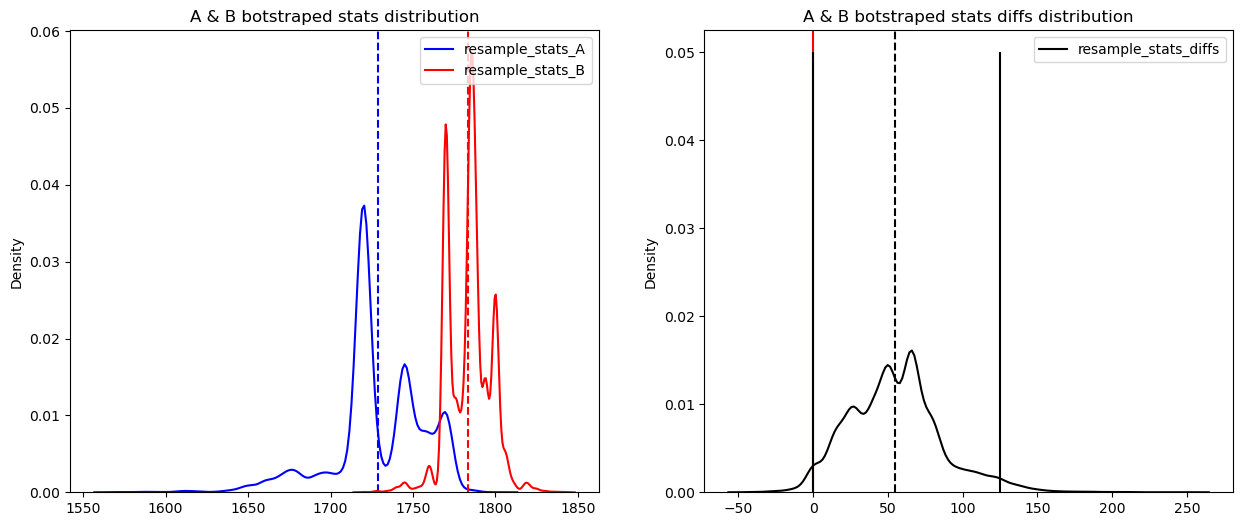

In [106]:
# прогоним проверку гипотезы через бутстрап на 0.8 квантиле распределения
np.random.seed(1)
boot_data = bootstrap_ab_test(sample_data_A = sample_0,
    sample_data_B = sample_1,
    stat = None,
    resample_num = 10000,
    alpha = 0.05,
    q = 0.8)

boot_data_plot(boot_data, alpha = 0.05)

In [108]:
# Отклоняется ли гипотеза H0 о равенстве квантилей распределения
print('Отклоняется ли гипотеза H0? ->', boot_data['p_value'] < 0.05)

Отклоняется ли гипотеза H0? -> False


In [110]:
# p_value, полученное с помощью бутстрапа
print('p_value полученное с помощью бутстрапа =', round(boot_data['p_value'], 5))

p_value полученное с помощью бутстрапа = 0.056


### 0.4 квантиль

H0 rejected!!!
A sample stat mean = 428.67482
B sample stat mean = 377.1179
Avg lift = -51.556920000000034
p-val = 0.0
Diffs ci: [-79. -23.]
stats diffs std =  11.527085673039803


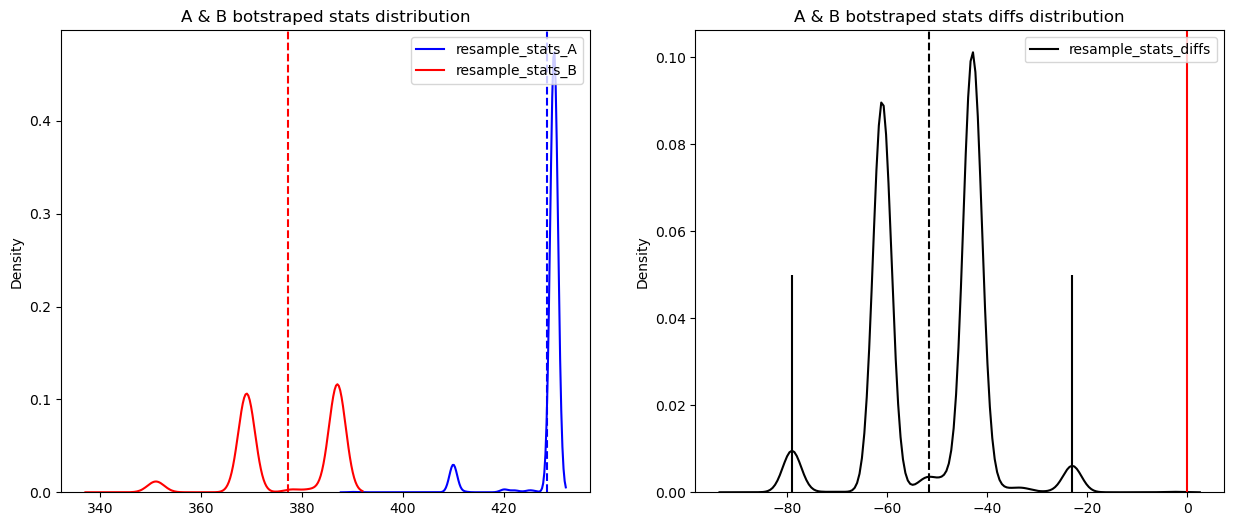

In [112]:
# прогоним проверку гипотезы через бутстрап на 0.4 квантиле распределения
np.random.seed(1)
boot_data = bootstrap_ab_test(sample_data_A = sample_0,
    sample_data_B = sample_1,
    stat = None,
    resample_num = 10000,
    alpha = 0.05,
    q = 0.4)
boot_data_plot(boot_data, alpha = 0.05)

In [114]:
# Отклоняется ли гипотеза H0 о равенстве квантилей распределения
print('Отклоняется ли гипотеза H0? ->', boot_data['p_value'] < 0.05)

Отклоняется ли гипотеза H0? -> True


In [116]:
# среднее разниц квантилей полученное с помощью бутстрапа
print('Средняя разница между квантилями полученная через бутстрап =', round(boot_data['resampled_diffs'].mean(), 1))

Средняя разница между квантилями полученная через бутстрап = -51.6


### 0.6 квантиль

H0 rejected!!!
A sample stat mean = 859.661045
B sample stat mean = 1020.4888
Avg lift = 160.82775499999997
p-val = 0.0
Diffs ci: [116. 172.]
stats diffs std =  16.884212475267383


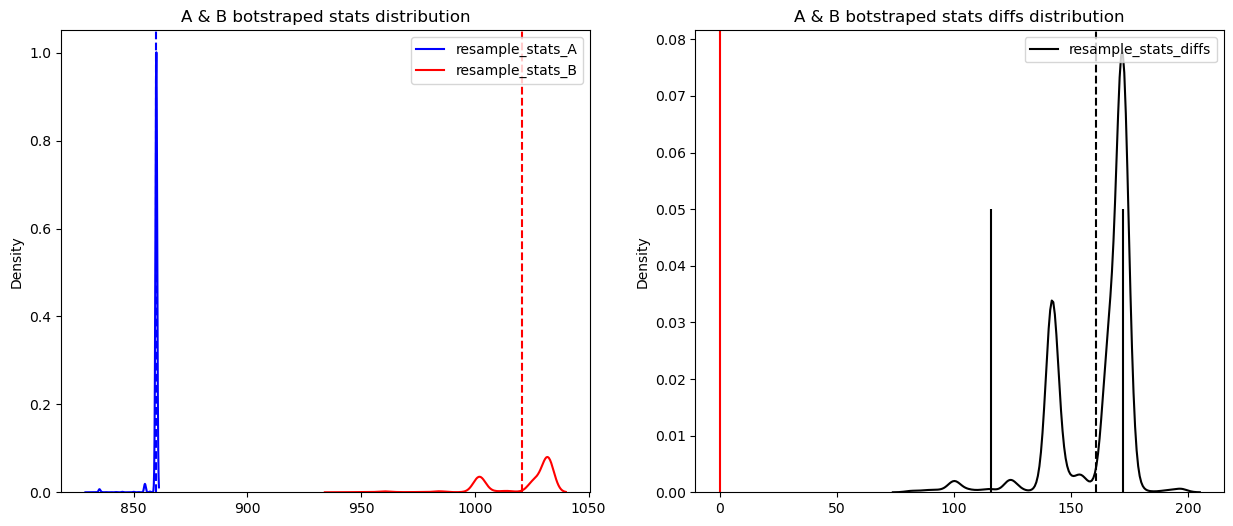

In [118]:
# прогоним проверку гипотезы через бутстрап на 0.6 квантиле распределения
np.random.seed(1)
boot_data = bootstrap_ab_test(sample_data_A = sample_0,
    sample_data_B = sample_1,
    stat = None,
    resample_num = 10000,
    alpha = 0.05,
    q = 0.65)
boot_data_plot(boot_data, alpha = 0.05)

In [129]:
# p_value, полученное с помощью бутстрапа
print('p_value полученное с помощью бутстрапа =', round(boot_data['p_value'], 5))

p_value полученное с помощью бутстрапа = 0.0


## Децильный анализ 

In [132]:
# график p-value, полученных через бутстрап для проверки гипотезы равенства перцентилей каждого перцентиля
perc_linspace = np.arange(start = 0.01, stop = 1, step = 0.01) # создаем массив квантиле по которым мы будем проверять гипотезу о равенстве квантиля

p_val_list = []
diffs_list = []
lower_ci_list = []
upper_ci_list = []

# для каждого определяемого квантиля проверяем гипотезу о равенстве квантилей с помощью бутстрапа
np.random.seed(1)
for i in tqdm(perc_linspace):
    boot_data = bootstrap_ab_test(sample_0,
                  sample_data_B = sample_1,
                  stat = np.mean,
                  resample_num = 2000,
                  alpha = (0.05/len(perc_linspace)), q = i) # не забываем штрафовать нашу альфа. Пока используем самый простой и страшный Бонферрони
    p_val_list.append(boot_data['p_value'])
    diffs_list.append(boot_data['resampled_diffs'].mean())
    lower_ci_list.append(boot_data['conf_int'][0])
    upper_ci_list.append(boot_data['conf_int'][1])
p_val_list = np.array(p_val_list)
diffs_list = np.array(diffs_list)
lower_ci_list = np.array(lower_ci_list)
upper_ci_list = np.array(upper_ci_list)

100%|██████████████████████████████████████████████████████████████████████████████████| 99/99 [02:33<00:00,  1.55s/it]


Target percentile =  0.01


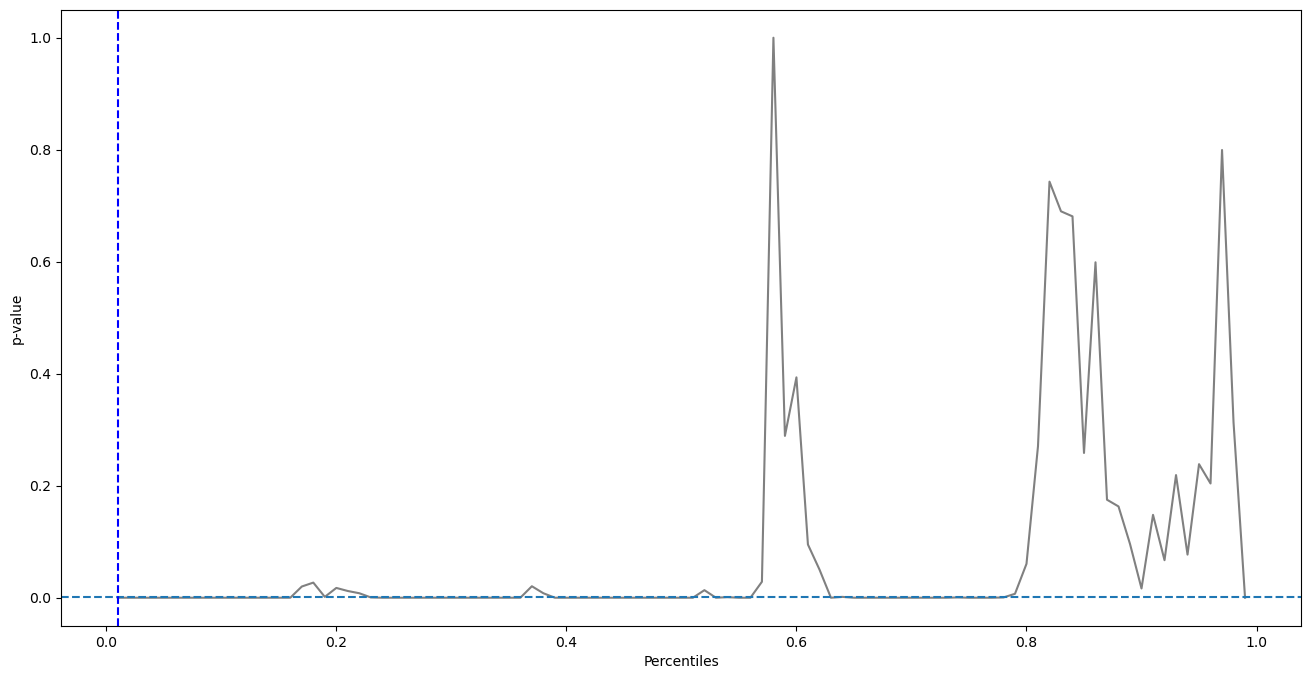

In [134]:
plt.figure(figsize=(16,8))
sns.lineplot(x = np.round(perc_linspace,2), y = p_val_list, color= 'gray')
plt.xlabel("Percentiles")
plt.ylabel("p-value")
plt.axhline(y = (0.05/len(perc_linspace)), linestyle = '--')
target_percentile = perc_linspace[p_val_list <= (0.05/len(perc_linspace))].min()
plt.axvline(target_percentile, linestyle = '--', color = 'blue')
print('Target percentile = ', perc_linspace[p_val_list <= (0.05/len(perc_linspace))].min())

Text(0, 0.5, 'Diffs and 95% CI with Bonferoni corr.')

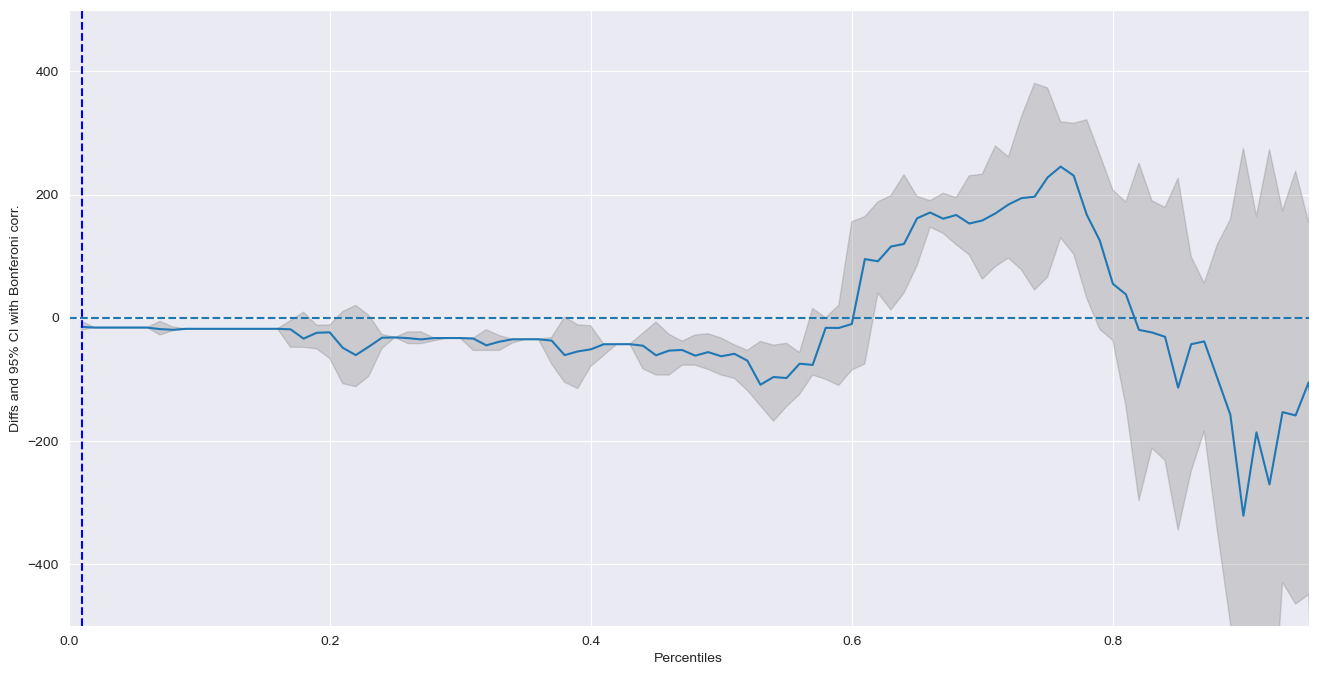

In [136]:
# посмотрим как выглядят доверительные интервалы
plt.figure(figsize=(16,8))
sns.set_style("darkgrid")
plt.ylim(-500,500)
plt.xlim(0,0.95)
sns.lineplot(x = perc_linspace, y = diffs_list, err_style='band')
plt.axhline(y = 0, linestyle = '--')
plt.axvline(target_percentile, linestyle = '--', color = 'blue')
plt.fill_between(perc_linspace, lower_ci_list, upper_ci_list, color = 'grey', alpha=0.3)
plt.xlabel("Percentiles")
plt.ylabel("Diffs and 95% CI with Bonferoni corr.")

In [138]:
# С какого перцентиля мы первый раз начинаем ловить эффект?
print('Мы начинаем ловить эффект с {} перцентиля'.format(round(target_percentile, 2)))

Мы начинаем ловить эффект с 0.01 перцентиля


In [140]:
# Какой абсолютный наблюдаемый эффект находит при проверке бутстрапом на этом квантиле?
print('Средняя разница для найденного квантиля составила =', round(diffs_list[perc_linspace == target_percentile][0], 1))

Средняя разница для найденного квантиля составила = -14.8


In [142]:
# С какого перцентия мы первый раз начинаем ловить положительный эффект между квантилями (квантиль группа 1 > квантиля группы 0)
valued_perc = perc_linspace[p_val_list <= (0.05/len(perc_linspace))]
valued_diffs = diffs_list[p_val_list <= (0.05/len(perc_linspace))]
target_positive_perc = valued_perc[np.argmax(valued_diffs > 0)]
print('При проверке бустрапом, мы первый раз начинаем ловить положительный эффект между квантилями с {} квантиля'.format(target_positive_perc))

При проверке бустрапом, мы первый раз начинаем ловить положительный эффект между квантилями с 0.63 квантиля


In [144]:
# Какой абсолютный наблюдаемый эффект находит при проверке бутстрапом на квантиле из симуляции?
print('Средняя разница для найденного квантиля составила =', round(diffs_list[perc_linspace == target_positive_perc][0], 1))

Средняя разница для найденного квантиля составила = 115.6


Бутстрап помогает тестировать более сложные гипотезы, например о квантилях распределения. С его помощью мы может производить поиск по всем децилям распределения. В конкретном кейсе это помогло найти области в которых цена отработала в сторону снижения ARPPU, и что более важно области в которых изменение цен увеличило ARPPU.